In [3]:
library(fpp2)
library(gridExtra)
library(grid)
library(quantmod)
library(RCurl)
library(dtwclust)
library(dtw)
library(stargazer)
library(dplyr)
library(sqldf)

In [9]:
# Get the S&P 500 companys' information
# Drop some companies due to data error
download = getURL("https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv")
SP500 = read.csv(text=download)
head(SP500)
SP500 = SP500[-which(SP500$Symbol %in% c("BRK.B","MON","UA","WELL")),]

Symbol,Name,Sector
MMM,3M Company,Industrials
AOS,A.O. Smith Corp,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology


In [10]:
# Acquire stock price information with quantmod package
stock_price = list()
stock_name = NULL
for(ticker in sub_SP500$Symbol){
  print(ticker)
  stock = getSymbols(ticker,src='yahoo',from = '2015-07-01', auto.assign = F)[,4]
  stock_price = c(stock_price,list(stock))
  stock_name = c(stock_name,ticker)
  Sys.sleep(2)
}
names(stock_price) = stock_name

[1] 501   3

In [11]:
# Save the final output
# save(stock_price, file="./data/stock_price.rds")
load('./data/stock_price.rds')

In [12]:
# Make sure the data quality
summary(sapply(stock_price,length))
less_data = names(which(sapply(stock_price,length) < 780))
SP500[SP500$Symbol %in% less_data,]

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   780.0   780.0   761.8   780.0   780.0 

,Symbol,Name,Sector
32,AEE,Ameren Corp,Utilities
39,AMP,Ameriprise Financial,Financials
81,BHF,Brighthouse Financial Inc,Financials
96,CBRE,CBRE Group,Real Estate
134,CSRA,CSRA Inc.,Information Technology
156,DPS,Dr Pepper Snapple Group,Consumer Staples
202,FTV,Fortive Corp,Industrials
206,GPS,Gap Inc.,Consumer Discretionary
231,HPE,Hewlett Packard Enterprise,Information Technology
275,KHC,Kraft Heinz Co,Consumer Staples


In [13]:
# Clean up data
stock_price = stock_price[-which(names(stock_price) %in% less_data)]
summary(sapply(stock_price,length))
summary(sapply(stock_price,function(x) sum(is.na(x))))
na_problem = sapply(stock_price,function(x) sum(is.na(x)))
na_problem[na_problem > 0]
stock_price = stock_price[-which(names(stock_price) == "BKNG")]
length(stock_price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    780     780     780     780     780     780 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.0000   0.0000   0.3854   0.0000 185.0000 

BKNG 
 185

[1] 479

In [14]:
# normalized stock price
normalized = function(x){
  m = mean(x)
  s = sd(x)
  n = (x-m)/s
  return(n)
}
normalized_price = lapply(stock_price,function(x) normalized(x))

In [15]:
# cluster
Final = NULL
for(i in seq(length(normalized_price))){
  d = data.frame(ind = seq(length(normalized_price[[i]])),stock_name = names(normalized_price)[i], price = normalized_price[[i]])
  names(d) = c("ind","stock_name","price")
  Final = rbind(Final,d)
}
Final_SP = NULL
for(i in seq(length(stock_price))){
  d = data.frame(ind = seq(length(stock_price[[i]])),stock_name = names(stock_price)[i], price = stock_price[[i]])
  names(d) = c("ind","stock_name","price")
  Final_SP = rbind(Final_SP,d)
}

In [16]:
# save(Final,Final_SP,file="./data/Stock_Price_DataFrame.rds")
load('./data/Stock_Price_DataFrame.rds')

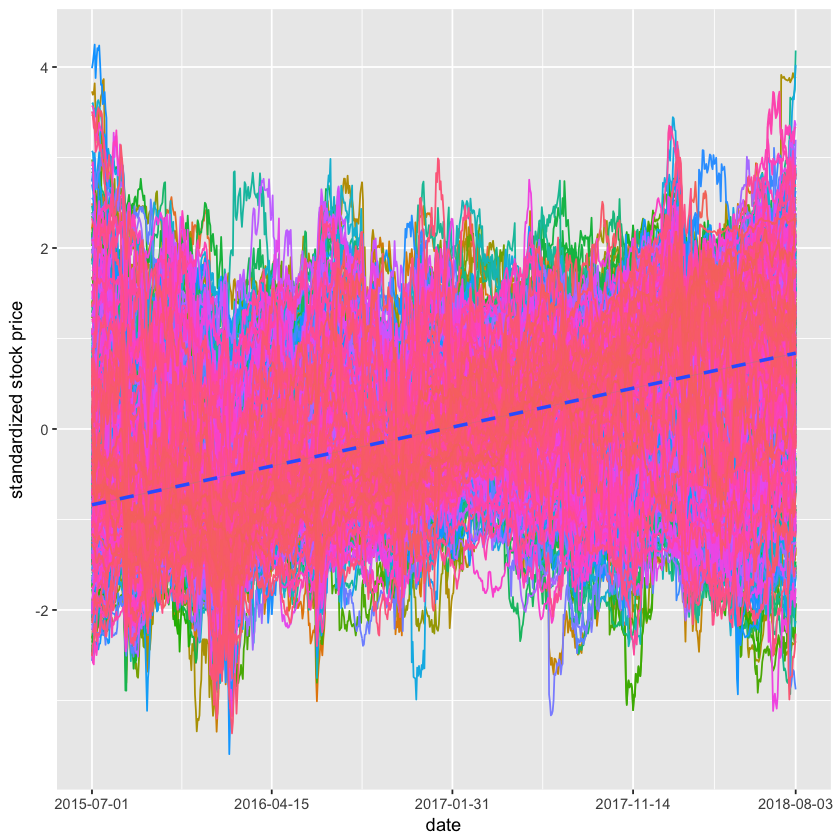

In [17]:
# standardized price time series
label_date = index(stock_price[[1]])
brek = c(1,200,400,600,780)
ggplot(data=Final,aes(x=ind,y=price))+geom_line(aes(colour=stock_name))+ theme(legend.position="none")+
  geom_smooth(method='lm',formula=y~x,linetype="dashed")+scale_x_continuous(breaks=brek,labels=label_date[brek])+
  xlab("date")+ylab("standardized stock price")


	Precomputing distance matrix...

Iteration 1: Changes / Distsum = 479 / 145766.3
Iteration 2: Changes / Distsum = 73 / 136582.1
Iteration 3: Changes / Distsum = 24 / 134170.8
Iteration 4: Changes / Distsum = 0 / 134170.8

	Elapsed time is 36.793 seconds.



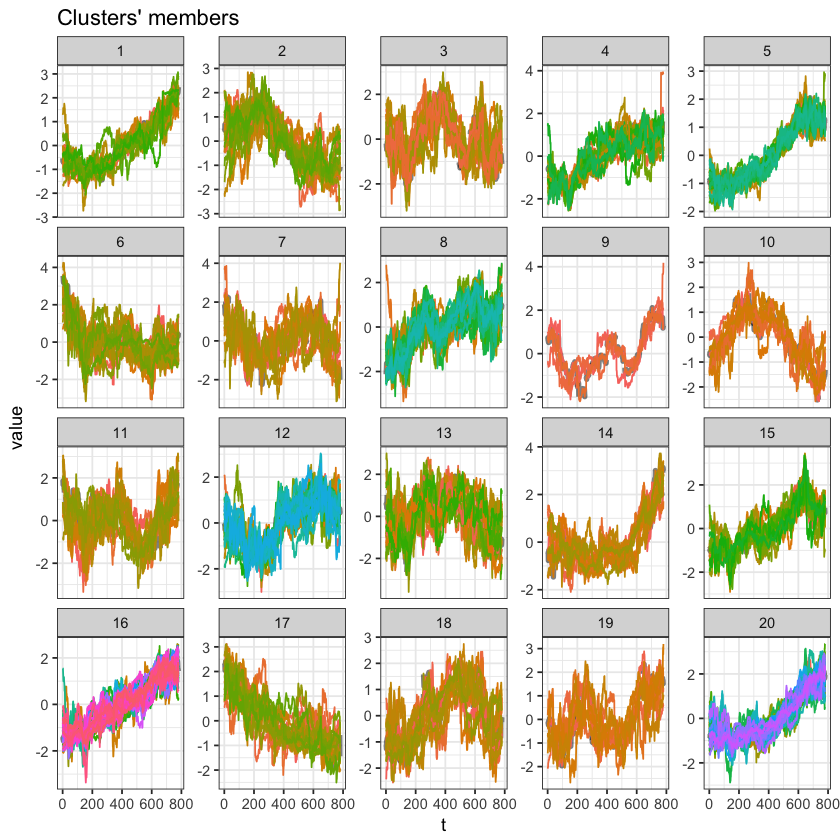

In [19]:
# time series clusters
dtw_cluster = tsclust(normalized_price, type="partitional",k=20,
                      distance="dtw_basic",centroid = "pam",seed=1234,trace=T,
                      args = tsclust_args(dist = list(window.size = 20L)))
plot(dtw_cluster)


	Precomputing distance matrix...

Iteration 1: Changes / Distsum = 479 / 262179.6
Iteration 2: Changes / Distsum = 122 / 231110.6
Iteration 3: Changes / Distsum = 3 / 230408.4
Iteration 4: Changes / Distsum = 6 / 230139.5
Iteration 5: Changes / Distsum = 0 / 230139.5

	Elapsed time is 31.175 seconds.



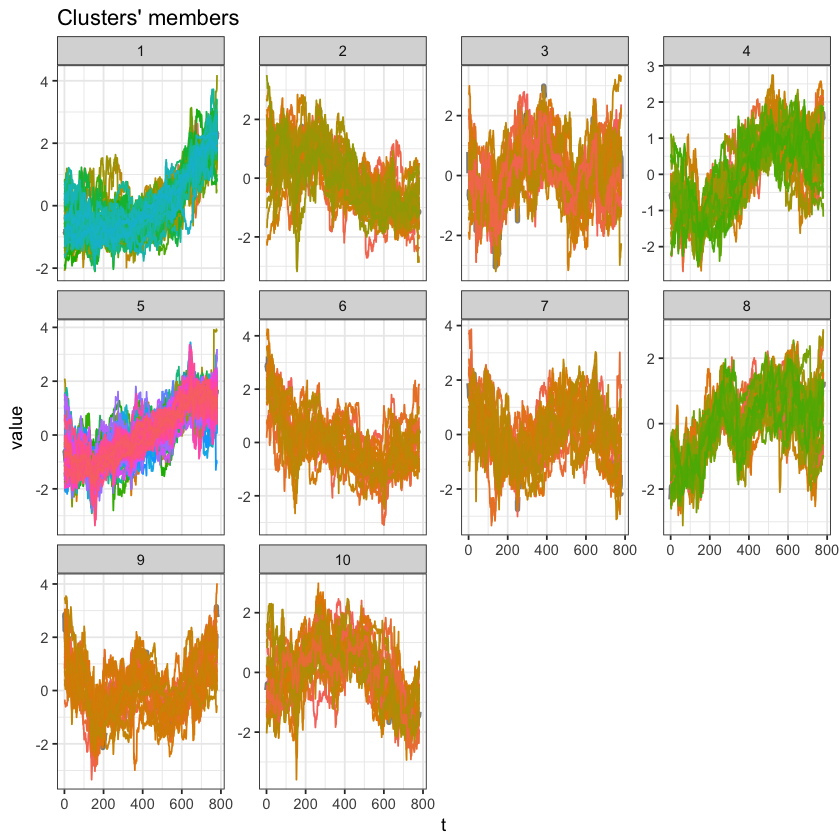

In [20]:
# We decided to Use 10 clusters with dtw with window size = 5 in the end
dtw_cluster = tsclust(normalized_price, type="partitional",k=10,
                      distance="dtw_basic",centroid = "pam",seed=1234,trace=T,
                      args = tsclust_args(dist = list(window.size = 5)))
plot(dtw_cluster)

In [22]:
cluster_data = data.frame(stock_name=names(normalized_price),cluster=dtw_cluster@cluster)
cluster_data = sqldf('select t1.*, t2.Name, t2.Sector from cluster_data t1 left join SP500 t2 on t1.stock_name = t2.Symbol')
head(cluster_data)

stock_name,cluster,Name,Sector
MMM,5,3M Company,Industrials
AOS,5,A.O. Smith Corp,Industrials
ABT,1,Abbott Laboratories,Health Care
ABBV,1,AbbVie Inc.,Health Care
ACN,1,Accenture plc,Information Technology
ATVI,5,Activision Blizzard,Information Technology


`geom_smooth()` using method = 'gam'


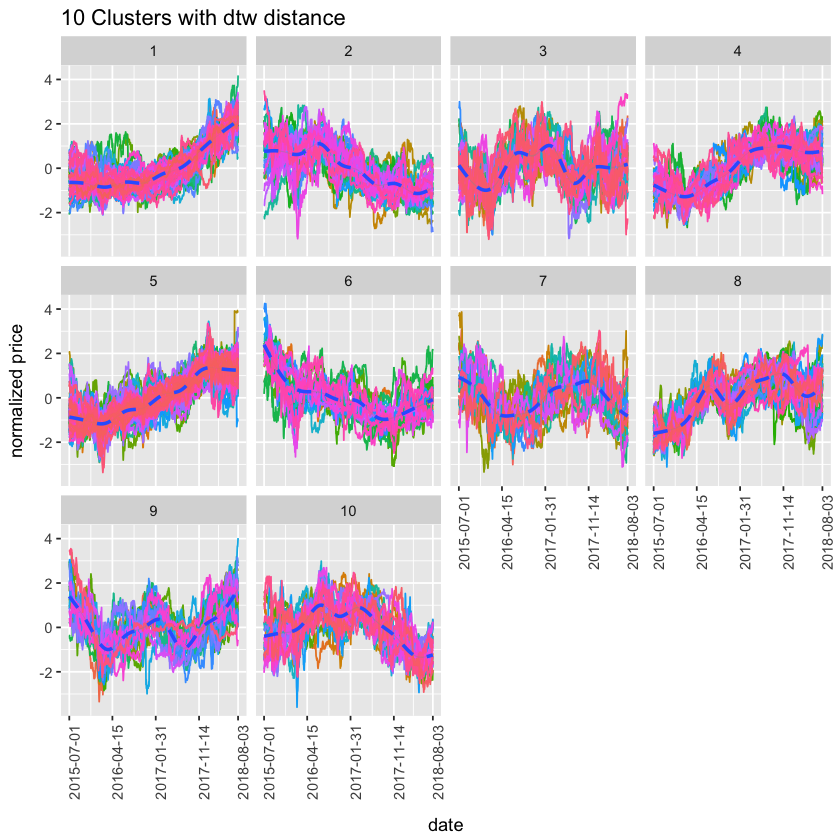

In [23]:
# Analyze each cluster
Final = sqldf('select t1.*, t2.cluster from Final t1 left join cluster_data t2 on t1.stock_name = t2.stock_name')
Final_SP = sqldf('select t1.*, t2.cluster from Final_SP t1 left join cluster_data t2 on t1.stock_name = t2.stock_name')
ggplot(data=Final,aes(x=ind,y=price))+geom_line(aes(colour=stock_name))+facet_wrap(~cluster)+
  theme(legend.position="none")+geom_smooth(method='auto',linetype="dashed")+
  xlab("date")+ylab("normalized price")+ggtitle("10 Clusters with dtw distance")+
  scale_x_continuous(breaks=brek,labels=label_date[brek])+theme(axis.text.x=element_text(angle = 90))

In [32]:
# Calculate returns
cluster_data$cluster = as.factor(cluster_data$cluster)
Final_ANA1 = split(Final,f=Final$cluster)
Final_SP_ANA1 = split(Final_SP,f=Final_SP$cluster)
Increase_Var = function(x){
  t = merge(x[x$ind==780,c("stock_name","price")],x[x$ind==1,c("stock_name","price")],by="stock_name")
  dif = t$price.x - t$price.y
  return(dif)
}
dif_var = sapply(Final_ANA1,function(x) mean(Increase_Var(x)))
dif_var_real = sapply(Final_SP_ANA1,function(x) mean(Increase_Var(x)))
dif_var_return_sd = sapply(Final_ANA1,Increase_Var)
return_dataframe_sd = NULL
for(i in names(dif_var_return_sd)){
  d = data.frame("cluster"=i,"return"=dif_var_return_sd[i])
  names(d) = c("cluster","return")
  return_dataframe_sd = rbind(return_dataframe_sd,d)
}

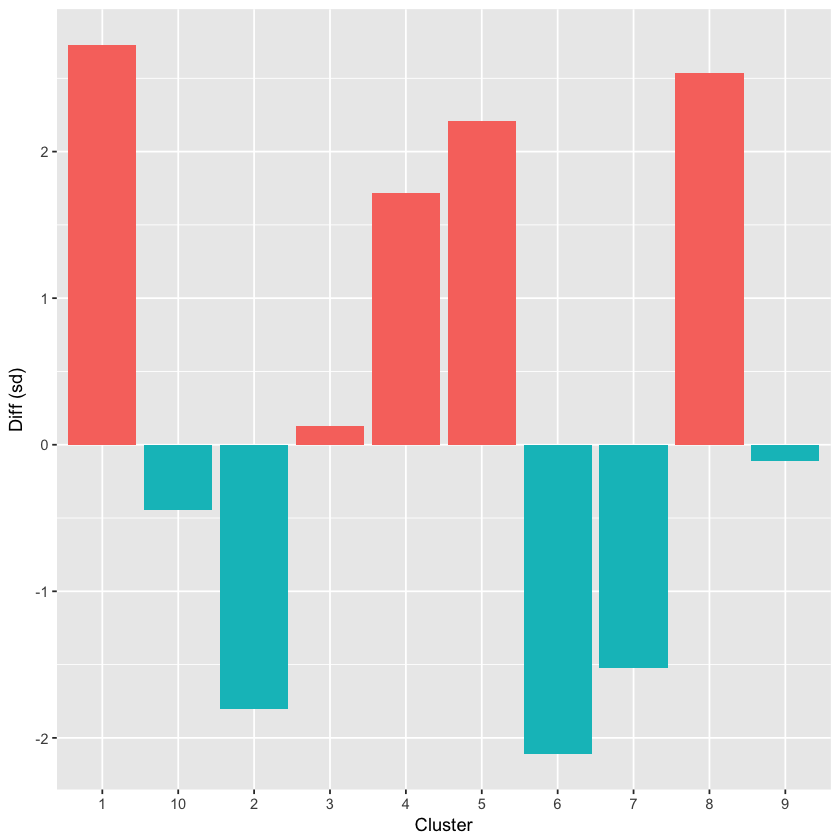

In [30]:
ggplot()+geom_bar(aes(x=as.character(index(dif_var)),y=dif_var,fill = ifelse(dif_var<0,"red","green")),stat='identity')+
  theme(legend.position = "none")+xlab("Cluster")+ylab("Diff (sd)")

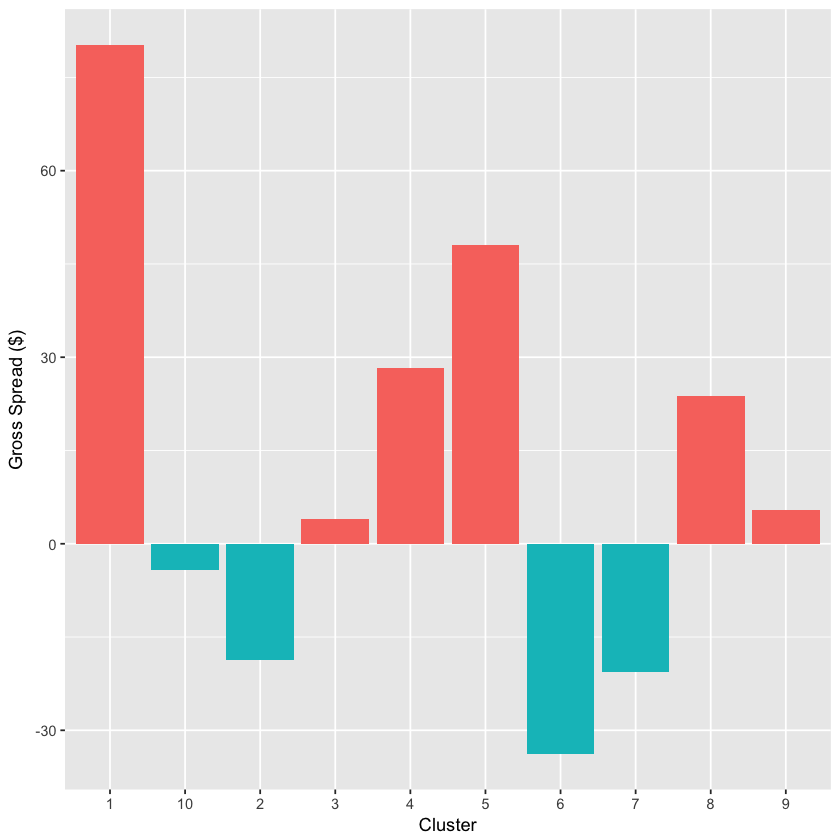

In [31]:
ggplot()+geom_bar(aes(x=as.character(index(dif_var_real)),y=dif_var_real,fill = ifelse(dif_var_real<0,"red","green")),stat='identity')+
  theme(legend.position = "none")+xlab("Cluster")+ylab("Gross Spread ($)")

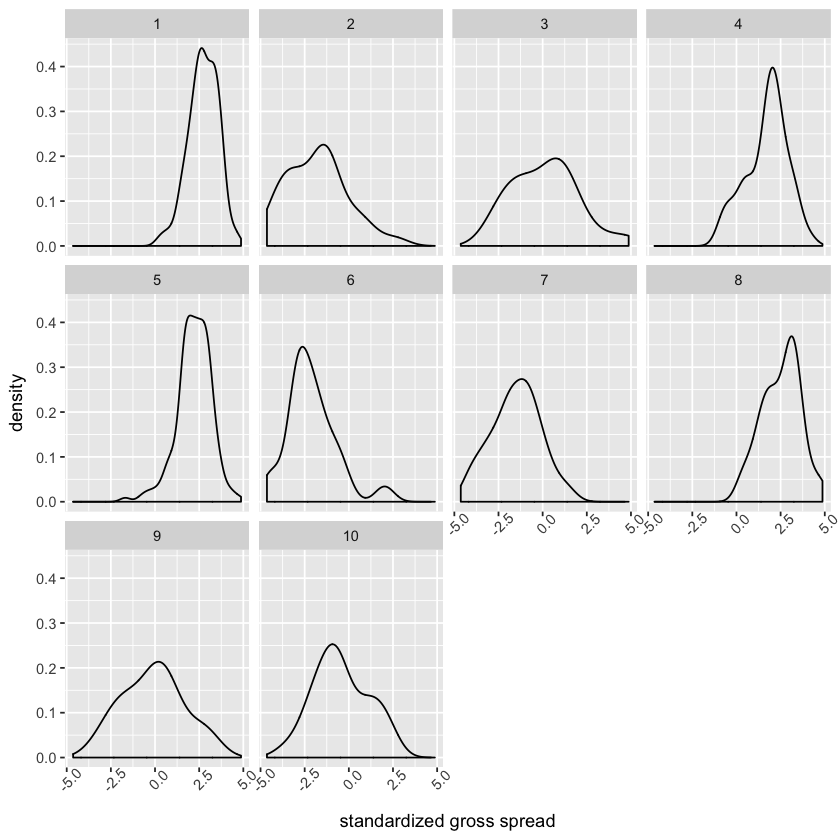

In [33]:
ggplot(data=return_dataframe_sd,aes(x = return))+geom_density()+facet_wrap(~cluster)+
  xlab("standardized gross spread")+theme(axis.text.x=element_text(angle = 45))